# 1. Importing libraries and reading data

In [1]:
%%capture
!pip install Bayesian-Optimization
!pip install xgboost
!pip install ray

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics
import math
import random
import itertools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
import os
import gc
import pdb
import ray
import keras
import xgboost
import tensorflow
from scipy import stats
from sklearn import metrics
from xgboost import XGBRegressor
from keras.models import load_model
from bayes_opt import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go

2024-09-03 18:23:54.435225: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 18:23:54.435319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 18:23:54.436926: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 18:23:54.446361: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
ray.init(ignore_reinit_error=True)

2024-09-03 18:23:57,592	WARNING services.py:2017 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67026944 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=8.91gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-09-03 18:23:58,727	INFO worker.py:1783 -- Started a local Ray instance.


Python version:,3.11.7
Ray version:,2.35.0


In [5]:
fosforo = pd.read_excel("Dados_B1_B7.xlsx")

In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [7]:
fosforo.columns = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'P']

In [8]:
dataset = fosforo[fosforo.columns[:7]]

In [9]:
target = fosforo['P']

# 2. Histograms / Skew

In [10]:
df = dataset.copy()
df['P'] = target

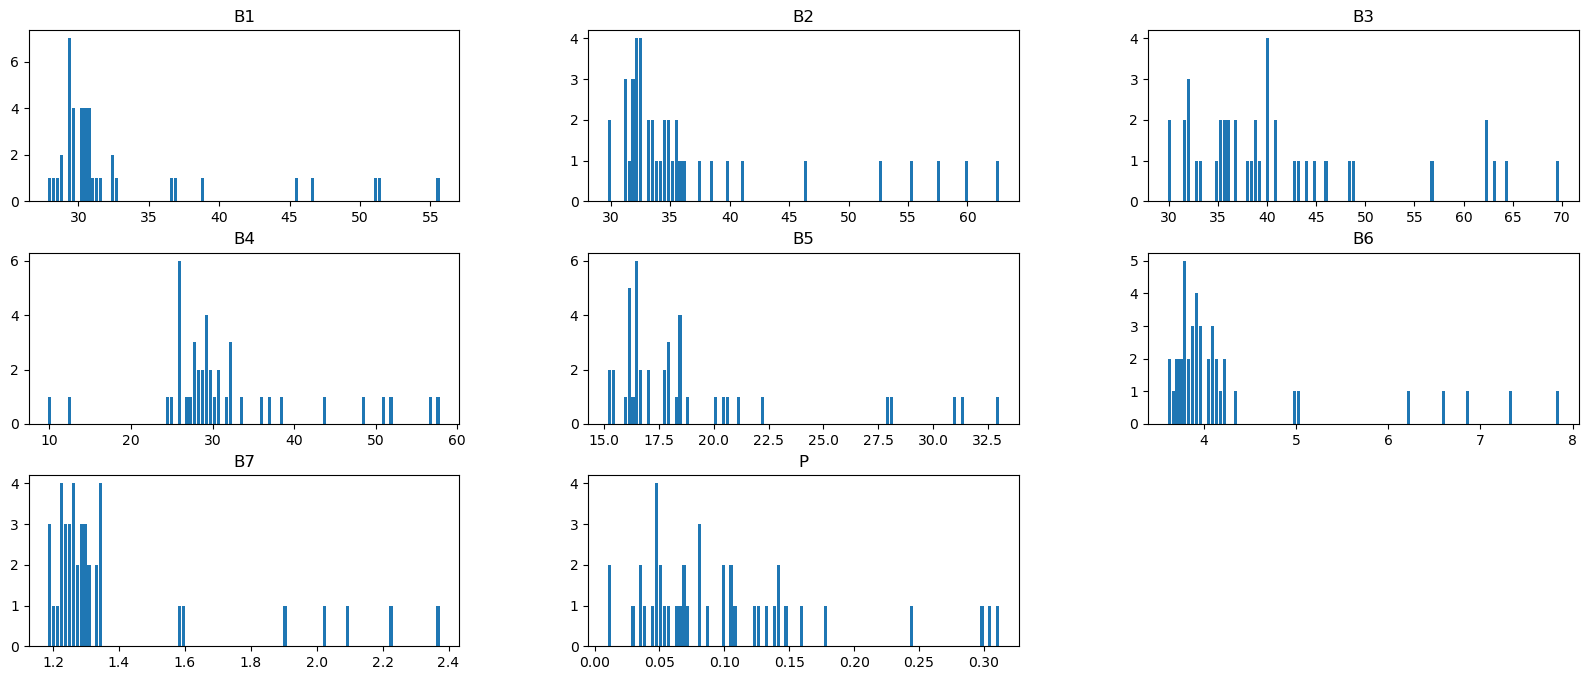

In [11]:
df.hist(
    figsize=(20, 8),
    grid = False,
    rwidth = 0.8,
    bins = 100
)
plt.show()

In [12]:
df.skew()

B1    2.202681
B2    2.021795
B3    1.406842
B4    0.991740
B5    2.011601
B6    2.300812
B7    2.306189
P     1.565691
dtype: float64

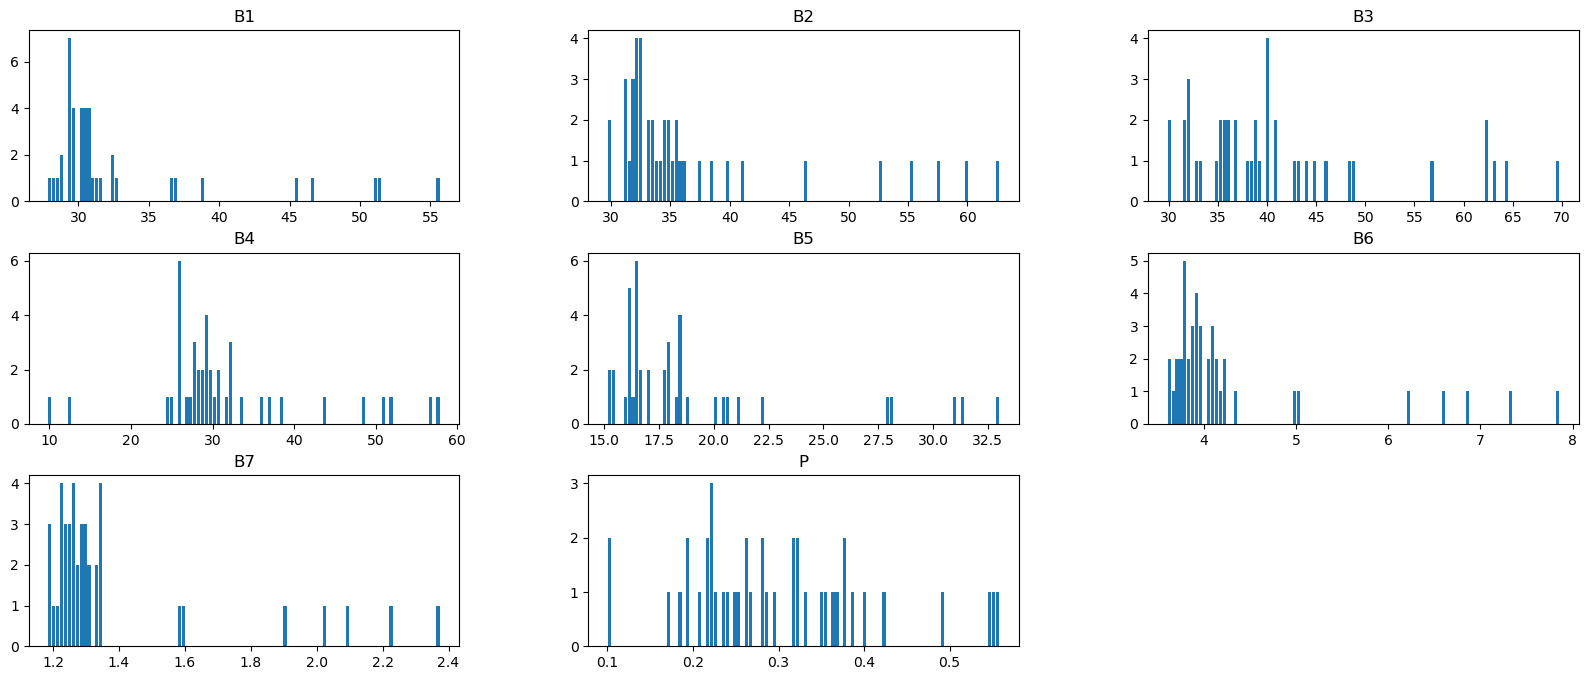

In [13]:
lbs = []

for col in df.columns:
  if abs(df.skew()[col]) > 0.9:
    _, l = stats.boxcox(df[col])[0:2]
    lbs.append(l)

target = np.sqrt(target)
df['P'] = target

df.hist(
    figsize=(20, 8),
    grid = False,
    rwidth = 0.8,
    bins = 100
)
plt.show()

In [14]:
lbs

[-6.756821209151582,
 -4.911524211710275,
 -2.1109315692577852,
 0.4495494212091018,
 -4.232461187722476,
 -5.997571733575384,
 -7.043710808407542,
 0.199055449196808]

In [15]:
df.skew()

B1    2.202681
B2    2.021795
B3    1.406842
B4    0.991740
B5    2.011601
B6    2.300812
B7    2.306189
P     0.712777
dtype: float64

In [16]:
dataset = df[df.columns[:7]]
target = df['P']

# 3. Boxplots

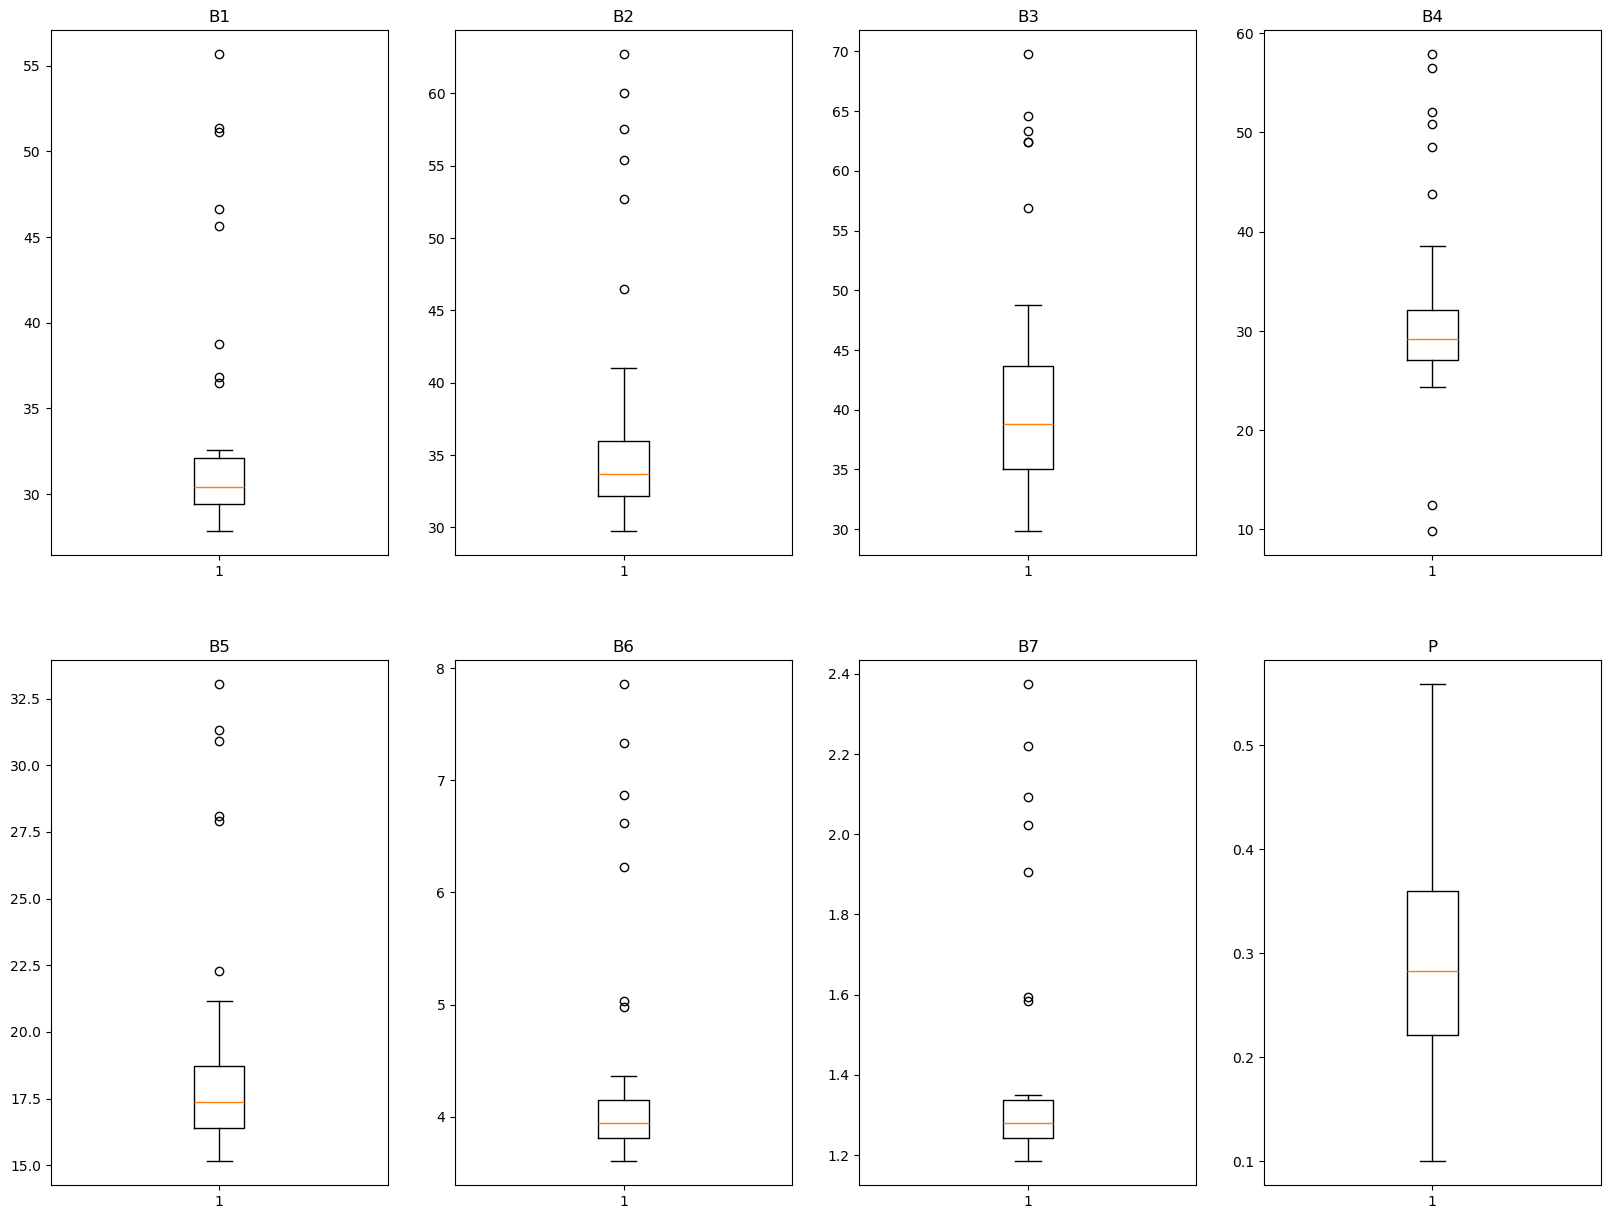

In [17]:
i=0
j=0

df = dataset.copy()
df['P'] = target

plt.rcParams["figure.figsize"] = (20,15)
fig, axs = plt.subplots(2, 4)
for col in df.columns:
  axs[i,j].set_title(col)
  axs[i,j].boxplot(df[col])
  j +=1

  if j > 3:
    j = 0
    i +=1

plt.show()

# 4. Outliers Removal

In [180]:
def outliers_treatment(dataset, target, method='remotion', median_p_dist=0.1, target_dist=0.1):
  if method == 'median':
    for i, p1 in enumerate(target):
      similar = [i]
      for j, p2 in enumerate(target):
        if abs(p1-p2) < target_dist*p1:
          similar.append(j)

      for k in range(len(dataset.columns)):
        for j in similar:
          if abs(dataset.iloc[i, k] - dataset.iloc[j, k]) > median_p_dist*dataset.iloc[i, k]:
            dataset.iloc[i, k] = statistics.median([dataset.iloc[c, k] for c in similar])
            dataset.iloc[j, k] = statistics.median([dataset.iloc[c, k] for c in similar])


  elif method == 'remotion':
    to_drop = []
    for i, p1 in enumerate(target):
      similar = [i]
      for j, p2 in enumerate(target):
        if abs(p1-p2) < target_dist*p1:
          similar.append(j)

      for k in range(len(dataset.columns)):
        if abs(dataset.iloc[i, k] - statistics.median([dataset.iloc[c, k] for c in similar])) >  median_p_dist*dataset.iloc[i, k]:
          to_drop.append(i)
          break

    dataset = dataset.drop(index=to_drop)
    dataset.reset_index(drop=True, inplace=True)
    target = target.drop(index=to_drop)
    target.reset_index(drop=True, inplace=True)

  return dataset, target


In [ ]:
to_drop = [val for val in target.index if target[val] > 0.4]
dataset = dataset.drop(index=to_drop)
dataset.reset_index(drop=True, inplace=True)
target = target.drop(index=to_drop)
target.reset_index(drop=True, inplace=True)

In [ ]:
dataset, target = outliers_treatment(dataset, target, method='remotion', median_p_dist=0.15)

In [ ]:
dataset

,B1,B2,B3,B4,B5,B6,B7
0,30.1162,33.4923,38.7866,28.9411,17.8240,3.8617,1.2464
1,30.6845,34.1537,38.8822,30.0438,18.4973,3.9169,1.2551
2,45.6215,52.6813,62.4212,48.5056,28.0955,6.6208,2.0224
3,30.6840,32.1027,32.9215,25.8750,16.4034,3.8543,1.2500
4,29.3897,31.5916,33.0158,27.0334,16.5559,3.9747,1.2844
5,28.7015,29.9586,29.8104,24.3255,15.1438,3.6037,1.1841
6,30.1640,32.1973,32.1590,25.7599,16.1637,3.8129,1.2419
7,30.0888,31.7055,31.7910,25.7599,16.1637,3.8129,1.2419
8,29.2660,31.2224,32.1123,26.0156,16.0711,3.8806,1.2598
9,32.5785,35.2413,38.0632,29.1410,18.7888,4.0355,1.3000


In [ ]:
target

0     0.375690
1     0.375500
2     0.324037
3     0.100000
4     0.100000
5     0.260768
6     0.221359
7     0.219089
8     0.225832
9     0.264575
10    0.219089
11    0.282843
12    0.293825
13    0.254296
14    0.250998
15    0.384708
16    0.221359
17    0.187083
18    0.361939
19    0.240832
20    0.234521
21    0.192354
22    0.223607
23    0.170294
24    0.370585
25    0.400000
26    0.353553
27    0.324037
28    0.316228
29    0.350714
30    0.284605
31    0.330151
32    0.194936
33    0.268328
34    0.209762
35    0.316228
36    0.282843
Name: P, dtype: float64

# 5. Polynomial Relations

In [18]:
for i in dataset.columns:
  dataset['ln('+str(i)+')'] = np.log(dataset[i])

for i in dataset.columns:
  dataset['1/' + str(i)] = 1/dataset[i]

In [19]:
dataset

,B1,B2,B3,B4,B5,B6,B7,ln(B1),ln(B2),ln(B3),ln(B4),ln(B5),ln(B6),ln(B7),1/B1,1/B2,1/B3,1/B4,1/B5,1/B6,1/B7,1/ln(B1),1/ln(B2),1/ln(B3),1/ln(B4),1/ln(B5),1/ln(B6),1/ln(B7)
0,29.5835,33.4172,40.1310,9.8038,17.8349,3.8763,1.2581,3.387217,3.509071,3.692149,2.282770,2.881157,1.354881,0.229603,0.033803,0.029925,0.024918,0.102001,0.056070,0.257978,0.794849,0.295228,0.284976,0.270845,0.438064,0.347083,0.738072,4.355350
1,29.5860,32.3914,36.8628,28.3816,16.6043,3.7379,1.2204,3.387301,3.477893,3.607203,3.345741,2.809662,1.318524,0.199179,0.033800,0.030872,0.027128,0.035234,0.060225,0.267530,0.819403,0.295220,0.287530,0.277223,0.298887,0.355915,0.758424,5.020618
2,30.1162,33.4923,38.7866,28.9411,17.8240,3.8617,1.2464,3.405063,3.511316,3.658075,3.365263,2.880546,1.351108,0.220259,0.033205,0.029858,0.025782,0.034553,0.056104,0.258953,0.802311,0.293680,0.284794,0.273368,0.297154,0.347156,0.740134,4.540101
3,29.4667,33.8746,40.8503,29.5920,17.6618,3.7854,1.2231,3.383261,3.522665,3.709914,3.387504,2.871404,1.331152,0.201389,0.033937,0.029521,0.024480,0.033793,0.056619,0.264173,0.817595,0.295573,0.283876,0.269548,0.295203,0.348262,0.751229,4.965524
4,30.6845,34.1537,38.8822,30.0438,18.4973,3.9169,1.2551,3.423758,3.530871,3.660537,3.402656,2.917625,1.365301,0.227215,0.032590,0.029279,0.025719,0.033285,0.054062,0.255304,0.796749,0.292077,0.283216,0.273184,0.293888,0.342745,0.732439,4.401113
5,45.6215,52.6813,62.4212,48.5056,28.0955,6.6208,2.0224,3.820379,3.964261,4.133905,3.881679,3.335609,1.890216,0.704285,0.021919,0.018982,0.016020,0.020616,0.035593,0.151039,0.494462,0.261754,0.252254,0.241902,0.257620,0.299795,0.529040,1.419880
6,30.6840,32.1027,32.9215,25.8750,16.4034,3.8543,1.2500,3.423741,3.468940,3.494126,3.253277,2.797489,1.349189,0.223144,0.032590,0.031150,0.030375,0.038647,0.060963,0.259450,0.800000,0.292078,0.288272,0.286195,0.307382,0.357463,0.741186,4.481420
7,29.3897,31.5916,33.0158,27.0334,16.5559,3.9747,1.2844,3.380644,3.452891,3.496986,3.297073,2.806743,1.379949,0.250292,0.034026,0.031654,0.030289,0.036991,0.060401,0.251591,0.778574,0.295802,0.289612,0.285961,0.303299,0.356285,0.724664,3.995339
8,28.7015,29.9586,29.8104,24.3255,15.1438,3.6037,1.1841,3.356949,3.399816,3.394857,3.191525,2.717591,1.281961,0.168983,0.034841,0.033379,0.033545,0.041109,0.066034,0.277493,0.844523,0.297890,0.294134,0.294563,0.313330,0.367973,0.780055,5.917755
9,30.1640,32.1973,32.1590,25.7599,16.1637,3.8129,1.2419,3.406649,3.471883,3.470692,3.248819,2.782768,1.338390,0.216642,0.033152,0.031059,0.031095,0.038820,0.061867,0.262268,0.805218,0.293544,0.288028,0.288127,0.307804,0.359354,0.747166,4.615900


In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=True)
poly_features = poly.fit_transform(dataset)
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(dataset.columns))

In [ ]:
original_columns = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Define a remote function to check each column
@ray.remote
def check_column(i, col, original_columns):
    col_splited = col.split()
    for oc in original_columns:
        condition_1 = (oc in col_splited) and ('1/' + oc in col_splited)
        condition_2 = ('ln(' + oc + ')' in col_splited) and ('1/ln(' + oc + ')' in col_splited)

        if condition_1 or condition_2:
            return i
    return None

futures = [check_column.remote(i, col, original_columns) for i, col in enumerate(poly_df.columns.tolist())]

results = ray.get(futures)

columns_to_drop = [i for i in results if i is not None]

poly_df = poly_df.drop(poly_df.columns[columns_to_drop], axis=1)

In [24]:
len(poly_df.columns)

4603568

In [20]:
# poly_df.to_csv('poly_df.csv', index=False)


poly_df = pd.read_csv(
    'poly_df.csv',
    low_memory=False,  # Process file in chunks to reduce memory usage
    dtype='float',       # Specifying dtypes can help reduce memory usage
    engine='c',        # Use C engine which is faster
    memory_map=True    # Use memory mapping to reduce memory footprint
)

In [ ]:
list(poly_df.columns)

# 6. Selection by Correlation

In [ ]:
def one_side_corr(data, target, method='spearman', target_corr=0.5, variables_corr=0.5):
    other_columns = [col for col in data.columns if col != target]
    values = []
    accepted_cols = []
    accepted_values = []
    for col in other_columns:
      corr_value = data[target].corr(data[col], method=method)
      if corr_value > target_corr:
        values.append((col, corr_value))

    values = sorted(values, key=lambda x: x[1], reverse=True)
    accepted_cols.append(values[0][0])
    accepted_values.append(values[0])

    for i in values:
      count = 0
      for col_acc in accepted_cols:
        if abs(data[col_acc].corr(data[i[0]], method=method)) > variables_corr:
          count += 1
          break
      if count == 0:
        accepted_cols.append(i[0])
        accepted_values.append(i)

    return accepted_values

In [ ]:
poly_df['P'] = target
poly_corr = one_side_corr(poly_df, 'P',method="spearman", target_corr=0, variables_corr=0.9)

In [ ]:
np.save('/content/drive/MyDrive/CNN_Chagas/fosforo/poly_corr.npy', np.array(poly_corr))

In [ ]:
poly_corr

[('B2 ln(B2)^2 ln(B6) 1/B1 1/B7 1/ln(B3)', 0.7412546419479165),
 ('B5 B6 B7^2 ln(B5) 1/B1 1/ln(B7)', 0.6513696605694936),
 ('B5^2 1/B1 1/B7 1/ln(B4)', 0.5921973575248592),
 ('B2 B3 B7 1/ln(B1)^3 1/ln(B7)', 0.5174908426588878),
 ('ln(B1) ln(B5) ln(B6)^2 1/B1 1/B7', 0.4567769766090824),
 ('B2^2 ln(B5) 1/B1 1/B4 1/ln(B1)', 0.4481205074262),
 ('B4 B6 ln(B1) 1/B7^2 1/ln(B3)^2', 0.44527454495511537),
 ('B1 B2 ln(B7) 1/B1 1/B2 1/ln(B7)', 0.4101629061894485),
 ('ln(B1) ln(B5)^3 ln(B6) 1/B5 1/B7', 0.40222936257996045),
 ('B3 ln(B7) 1/B3 1/ln(B7)', 0.3959656143862902),
 ('B2 B6 ln(B1) 1/B1 1/B7 1/ln(B2)^2', 0.3859836601408523),
 ('B4 ln(B6) ln(B7) 1/B4 1/ln(B6) 1/ln(B7)', 0.36576135704199697),
 ('B2^2 B5 1/B3 1/B7^2', 0.3519506922574654),
 ('ln(B1)^3 ln(B2) ln(B3) 1/ln(B5) 1/ln(B6)', 0.34127833299089805),
 ('B3 B7 ln(B2) ln(B3) 1/B1 1/B4 1/ln(B5)', 0.33653506220575696),
 ('ln(B6) ln(B7) 1/ln(B6) 1/ln(B7)', 0.31006139474764705),
 ('B4^2 ln(B4)^2 1/B2 1/B3 1/ln(B6)', 0.3084311828037963),
 ('B1 B2 

In [ ]:
poly_df = poly_df[[x[0] for x in poly_corr]]

In [236]:
y = target
x = poly_df

# 7.PCA

In [ ]:
# scaler = StandardScaler()
# x_scaled = scaler.fit_transform(x)
pca = PCA()
x_pca = pca.fit_transform(poly_df)

In [ ]:
cumulative_variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

val = list(range(1, len(cumulative_variance)+1))
fig = go.Figure(data=go.Scatter(x = val, y = cumulative_variance, mode='lines+markers'))
fig.update_layout(
    xaxis=dict(title='PCs', dtick=10 ,showgrid=True),
    yaxis=dict(title='Cumulative variance',  dtick=10, showgrid=True)
)
fig.show()

In [ ]:
x = pd.DataFrame()
y = target

for i, val in enumerate(np.transpose(x_pca[:, :41])[0:]):
  x['pc_' + str(i+1)] = val

# 8. Train/Test Split

In [22]:
from sklearn.model_selection import StratifiedKFold, KFold

In [27]:
def fold_visualizer(data, fold_idxs, seed_num):
    num_folds = len(fold_idxs)
    num_rows = num_folds // 2 + (num_folds % 2)  # Calculate the number of rows needed
    fig, axs = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))
    
    fig.suptitle("Seed: " + str(seed_num), fontsize=16)
    
    # Flatten the axs array if it is 2D
    axs = axs.flatten()
    
    for fold_id, (train_ids, val_ids) in enumerate(fold_idxs):
        ax = axs[fold_id]
        sns.histplot(data=data[train_ids],
                     kde=True,
                     stat="density",
                     alpha=0.15,
                     label="Train Set",
                     bins=5,
                     line_kws={"linewidth":4},
                     ax=ax)
        sns.histplot(data=data[val_ids],
                     kde=True,
                     stat="density",
                     color="darkorange",
                     alpha=0.15,
                     label="Validation Set",
                     bins=5,
                     line_kws={"linewidth":4},
                     ax=ax)
        ax.legend()
        ax.set_title("Split " + str(fold_id+1))
    
    # Hide any unused subplots
    for i in range(num_folds, len(axs)):
        axs[i].axis('off')
    
    plt.show()

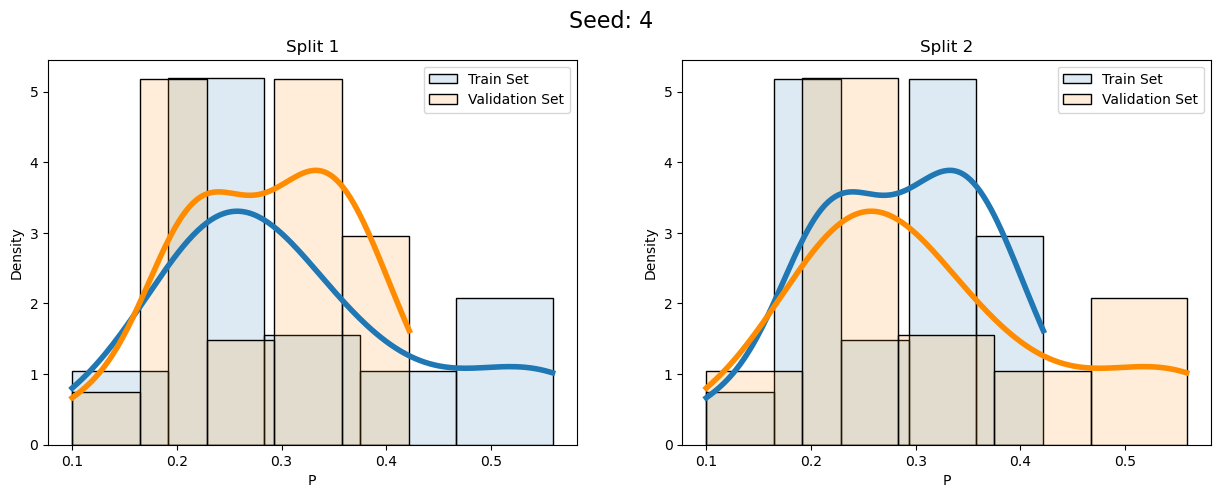

In [28]:
plt.rcParams["figure.figsize"] = (8,5)


baseline_kfold = list(KFold(2,
                            shuffle=True,
                            random_state=3
                            ).split(target))
fold_visualizer(data=target,
                fold_idxs=baseline_kfold,
                seed_num=4)

In [29]:
def create_cont_folds(df, n_s=8, n_grp=10, seed=1):

    skf = StratifiedKFold(n_splits=n_s, shuffle=True, random_state=seed)
    grp = pd.cut(df, n_grp, labels=False)
    target = grp

    fold_nums = np.zeros(len(df))
    for fold_no, (t, v) in enumerate(skf.split(target, target)):
        fold_nums[v] = fold_no

    cv_splits = []

    for i in range(n_s):
        test_indices = np.argwhere(fold_nums==i).flatten()
        train_indices = list(set(range(len(df))) - set(test_indices))
        cv_splits.append((train_indices, test_indices))

    return cv_splits

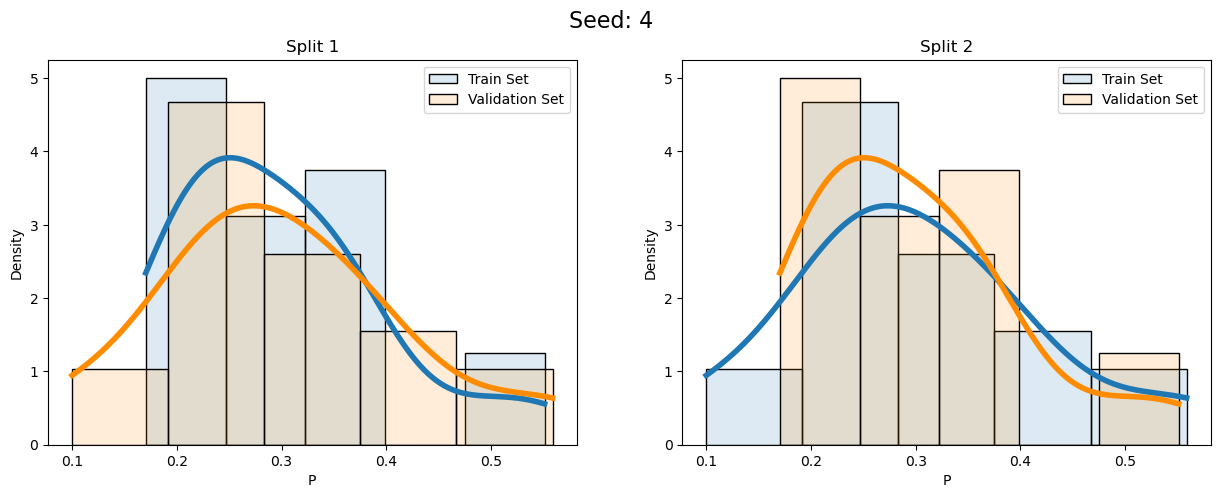

In [30]:
num_of_folds = 2
num_of_groups = 5

cv_splits = create_cont_folds(target, n_s=num_of_folds, n_grp=num_of_groups, seed=4)
fold_visualizer(data=target,
                fold_idxs=cv_splits,
                seed_num=4)

In [244]:
cv_splits = create_cont_folds(y, n_s=8, n_grp=10, seed=4)
x_tr = x.iloc[cv_splits[5][0]]
y_tr = y.iloc[cv_splits[5][0]]
x_te = x.iloc[cv_splits[5][1]]
y_te = y.iloc[cv_splits[5][1]]

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  warnings.warn(


# 9. Variable Selection

## 9.1. Boruta

In [ ]:
%%capture
!pip install BorutaShap
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [ ]:
import catboost as cb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from BorutaShap import BorutaShap, load_data
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from  sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

### Random Forest

In [ ]:
selected_features = []

In [ ]:
forest = RandomForestRegressor(
   n_jobs = -1, n_estimators=200
)

Feature_Selector = BorutaShap(model=forest,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_tr, y=y_tr, n_trials=100, random_state=0)

selected_features += Feature_Selector.accepted
selected_features += Feature_Selector.tentative

  0%|          | 0/100 [00:00<?, ?it/s]

5 attributes confirmed important: ['B5 B6 B7^2 ln(B5) 1/B1 1/ln(B7)', 'B5^2 1/B1 1/B7 1/ln(B4)', 'ln(B1) ln(B5) ln(B6)^2 1/B1 1/B7', 'B2^2 ln(B5) 1/B1 1/B4 1/ln(B1)', 'B2 ln(B2)^2 ln(B6) 1/B1 1/B7 1/ln(B3)']
12 attributes confirmed unimportant: ['B1 B2 ln(B2) 1/B1 1/B2 1/ln(B2)', 'B4^2 ln(B3) 1/B4^2 1/ln(B3)', 'B2 B6 ln(B1) 1/B1 1/B7 1/ln(B2)^2', 'B4 B6 ln(B1) 1/B7^2 1/ln(B3)^2', 'B3 ln(B7) 1/B3 1/ln(B7)', 'B1 B2 ln(B7) 1/B1 1/B2 1/ln(B7)', 'ln(B1)^3 ln(B2) ln(B3) 1/ln(B5) 1/ln(B6)', 'B4 ln(B6) ln(B7) 1/B4 1/ln(B6) 1/ln(B7)', 'B2^2 B5 1/B3 1/B7^2', 'B3 B7 ln(B2) ln(B3) 1/B1 1/B4 1/ln(B5)', 'B4^2 ln(B4)^2 1/B2 1/B3 1/ln(B6)', 'ln(B6) ln(B7) 1/ln(B6) 1/ln(B7)']
2 tentative attributes remains: ['ln(B1) ln(B5)^3 ln(B6) 1/B5 1/B7', 'B2 B3 B7 1/ln(B1)^3 1/ln(B7)']


### Gradient Boosting

In [ ]:
gb = GradientBoostingRegressor(
   n_estimators=200
)

Feature_Selector = BorutaShap(model=gb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_tr, y=y_tr, n_trials=100, random_state=0)

selected_features += Feature_Selector.accepted
selected_features += Feature_Selector.tentative

  0%|          | 0/100 [00:00<?, ?it/s]

4 attributes confirmed important: ['B2^2 ln(B5) 1/B1 1/B4 1/ln(B1)', 'ln(B1) ln(B5) ln(B6)^2 1/B1 1/B7', 'B5 B6 B7^2 ln(B5) 1/B1 1/ln(B7)', 'B2 ln(B2)^2 ln(B6) 1/B1 1/B7 1/ln(B3)']
13 attributes confirmed unimportant: ['B1 B2 ln(B2) 1/B1 1/B2 1/ln(B2)', 'B4^2 ln(B3) 1/B4^2 1/ln(B3)', 'B5^2 1/B1 1/B7 1/ln(B4)', 'B2 B6 ln(B1) 1/B1 1/B7 1/ln(B2)^2', 'B4 B6 ln(B1) 1/B7^2 1/ln(B3)^2', 'B3 ln(B7) 1/B3 1/ln(B7)', 'B1 B2 ln(B7) 1/B1 1/B2 1/ln(B7)', 'ln(B1)^3 ln(B2) ln(B3) 1/ln(B5) 1/ln(B6)', 'B4 ln(B6) ln(B7) 1/B4 1/ln(B6) 1/ln(B7)', 'B2^2 B5 1/B3 1/B7^2', 'B3 B7 ln(B2) ln(B3) 1/B1 1/B4 1/ln(B5)', 'B4^2 ln(B4)^2 1/B2 1/B3 1/ln(B6)', 'ln(B6) ln(B7) 1/ln(B6) 1/ln(B7)']
2 tentative attributes remains: ['ln(B1) ln(B5)^3 ln(B6) 1/B5 1/B7', 'B2 B3 B7 1/ln(B1)^3 1/ln(B7)']


### CatBoost

In [ ]:
ctb = CatBoostRegressor(iterations=200)

# no model selected default is Random Forest, if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=ctb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_tr, y=y_tr, n_trials=100, random_state=0)

selected_features += Feature_Selector.accepted
selected_features += Feature_Selector.tentative

  0%|          | 0/100 [00:00<?, ?it/s]

4 attributes confirmed important: ['B2^2 ln(B5) 1/B1 1/B4 1/ln(B1)', 'ln(B1) ln(B5) ln(B6)^2 1/B1 1/B7', 'B5 B6 B7^2 ln(B5) 1/B1 1/ln(B7)', 'B2 ln(B2)^2 ln(B6) 1/B1 1/B7 1/ln(B3)']
14 attributes confirmed unimportant: ['B1 B2 ln(B2) 1/B1 1/B2 1/ln(B2)', 'B4^2 ln(B3) 1/B4^2 1/ln(B3)', 'B2 B6 ln(B1) 1/B1 1/B7 1/ln(B2)^2', 'B4 B6 ln(B1) 1/B7^2 1/ln(B3)^2', 'ln(B1) ln(B5)^3 ln(B6) 1/B5 1/B7', 'B3 ln(B7) 1/B3 1/ln(B7)', 'B1 B2 ln(B7) 1/B1 1/B2 1/ln(B7)', 'ln(B1)^3 ln(B2) ln(B3) 1/ln(B5) 1/ln(B6)', 'B2 B3 B7 1/ln(B1)^3 1/ln(B7)', 'B4 ln(B6) ln(B7) 1/B4 1/ln(B6) 1/ln(B7)', 'B2^2 B5 1/B3 1/B7^2', 'B3 B7 ln(B2) ln(B3) 1/B1 1/B4 1/ln(B5)', 'B4^2 ln(B4)^2 1/B2 1/B3 1/ln(B6)', 'ln(B6) ln(B7) 1/ln(B6) 1/ln(B7)']
1 tentative attributes remains: ['B5^2 1/B1 1/B7 1/ln(B4)']


### XGBoost

In [ ]:
xgb = XGBRegressor(n_estimators=200)

# no model selected default is Random Forest, if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=xgb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_tr, y=y_tr, n_trials=100, random_state=0)

selected_features += Feature_Selector.accepted
selected_features += Feature_Selector.tentative

  0%|          | 0/100 [00:00<?, ?it/s]

5 attributes confirmed important: ['B5 B6 B7^2 ln(B5) 1/B1 1/ln(B7)', 'ln(B1) ln(B5) ln(B6)^2 1/B1 1/B7', 'B2 B3 B7 1/ln(B1)^3 1/ln(B7)', 'B2^2 ln(B5) 1/B1 1/B4 1/ln(B1)', 'B2 ln(B2)^2 ln(B6) 1/B1 1/B7 1/ln(B3)']
14 attributes confirmed unimportant: ['B1 B2 ln(B2) 1/B1 1/B2 1/ln(B2)', 'B4^2 ln(B3) 1/B4^2 1/ln(B3)', 'B5^2 1/B1 1/B7 1/ln(B4)', 'B2 B6 ln(B1) 1/B1 1/B7 1/ln(B2)^2', 'B4 B6 ln(B1) 1/B7^2 1/ln(B3)^2', 'ln(B1) ln(B5)^3 ln(B6) 1/B5 1/B7', 'B3 ln(B7) 1/B3 1/ln(B7)', 'B1 B2 ln(B7) 1/B1 1/B2 1/ln(B7)', 'ln(B1)^3 ln(B2) ln(B3) 1/ln(B5) 1/ln(B6)', 'B4 ln(B6) ln(B7) 1/B4 1/ln(B6) 1/ln(B7)', 'B2^2 B5 1/B3 1/B7^2', 'B3 B7 ln(B2) ln(B3) 1/B1 1/B4 1/ln(B5)', 'B4^2 ln(B4)^2 1/B2 1/B3 1/ln(B6)', 'ln(B6) ln(B7) 1/ln(B6) 1/ln(B7)']
0 tentative attributes remains: []


In [ ]:
selected_features = list(dict.fromkeys(selected_features))

x_tr = x_tr[selected_features]
x_te = x_te[selected_features]
df = x[selected_features].copy()
df['P'] = y

In [ ]:
eigenvectors = pca.components_
eigenvectors = [eigenvectors[1]]
variables = poly_df.columns  # Adjust this based on your actual variable names

for i, comp in enumerate(eigenvectors):
    terms = [f"{comp[j]:.3f}*{variables[j]}" for j in range(len(variables)) if round(comp[j],3) != 0]
    formula = " + ".join(terms)
    print(f"Principal Component {i+1}: {formula}")

NameError: name 'pca' is not defined

# 10. Bivariate analysis / correlation between data

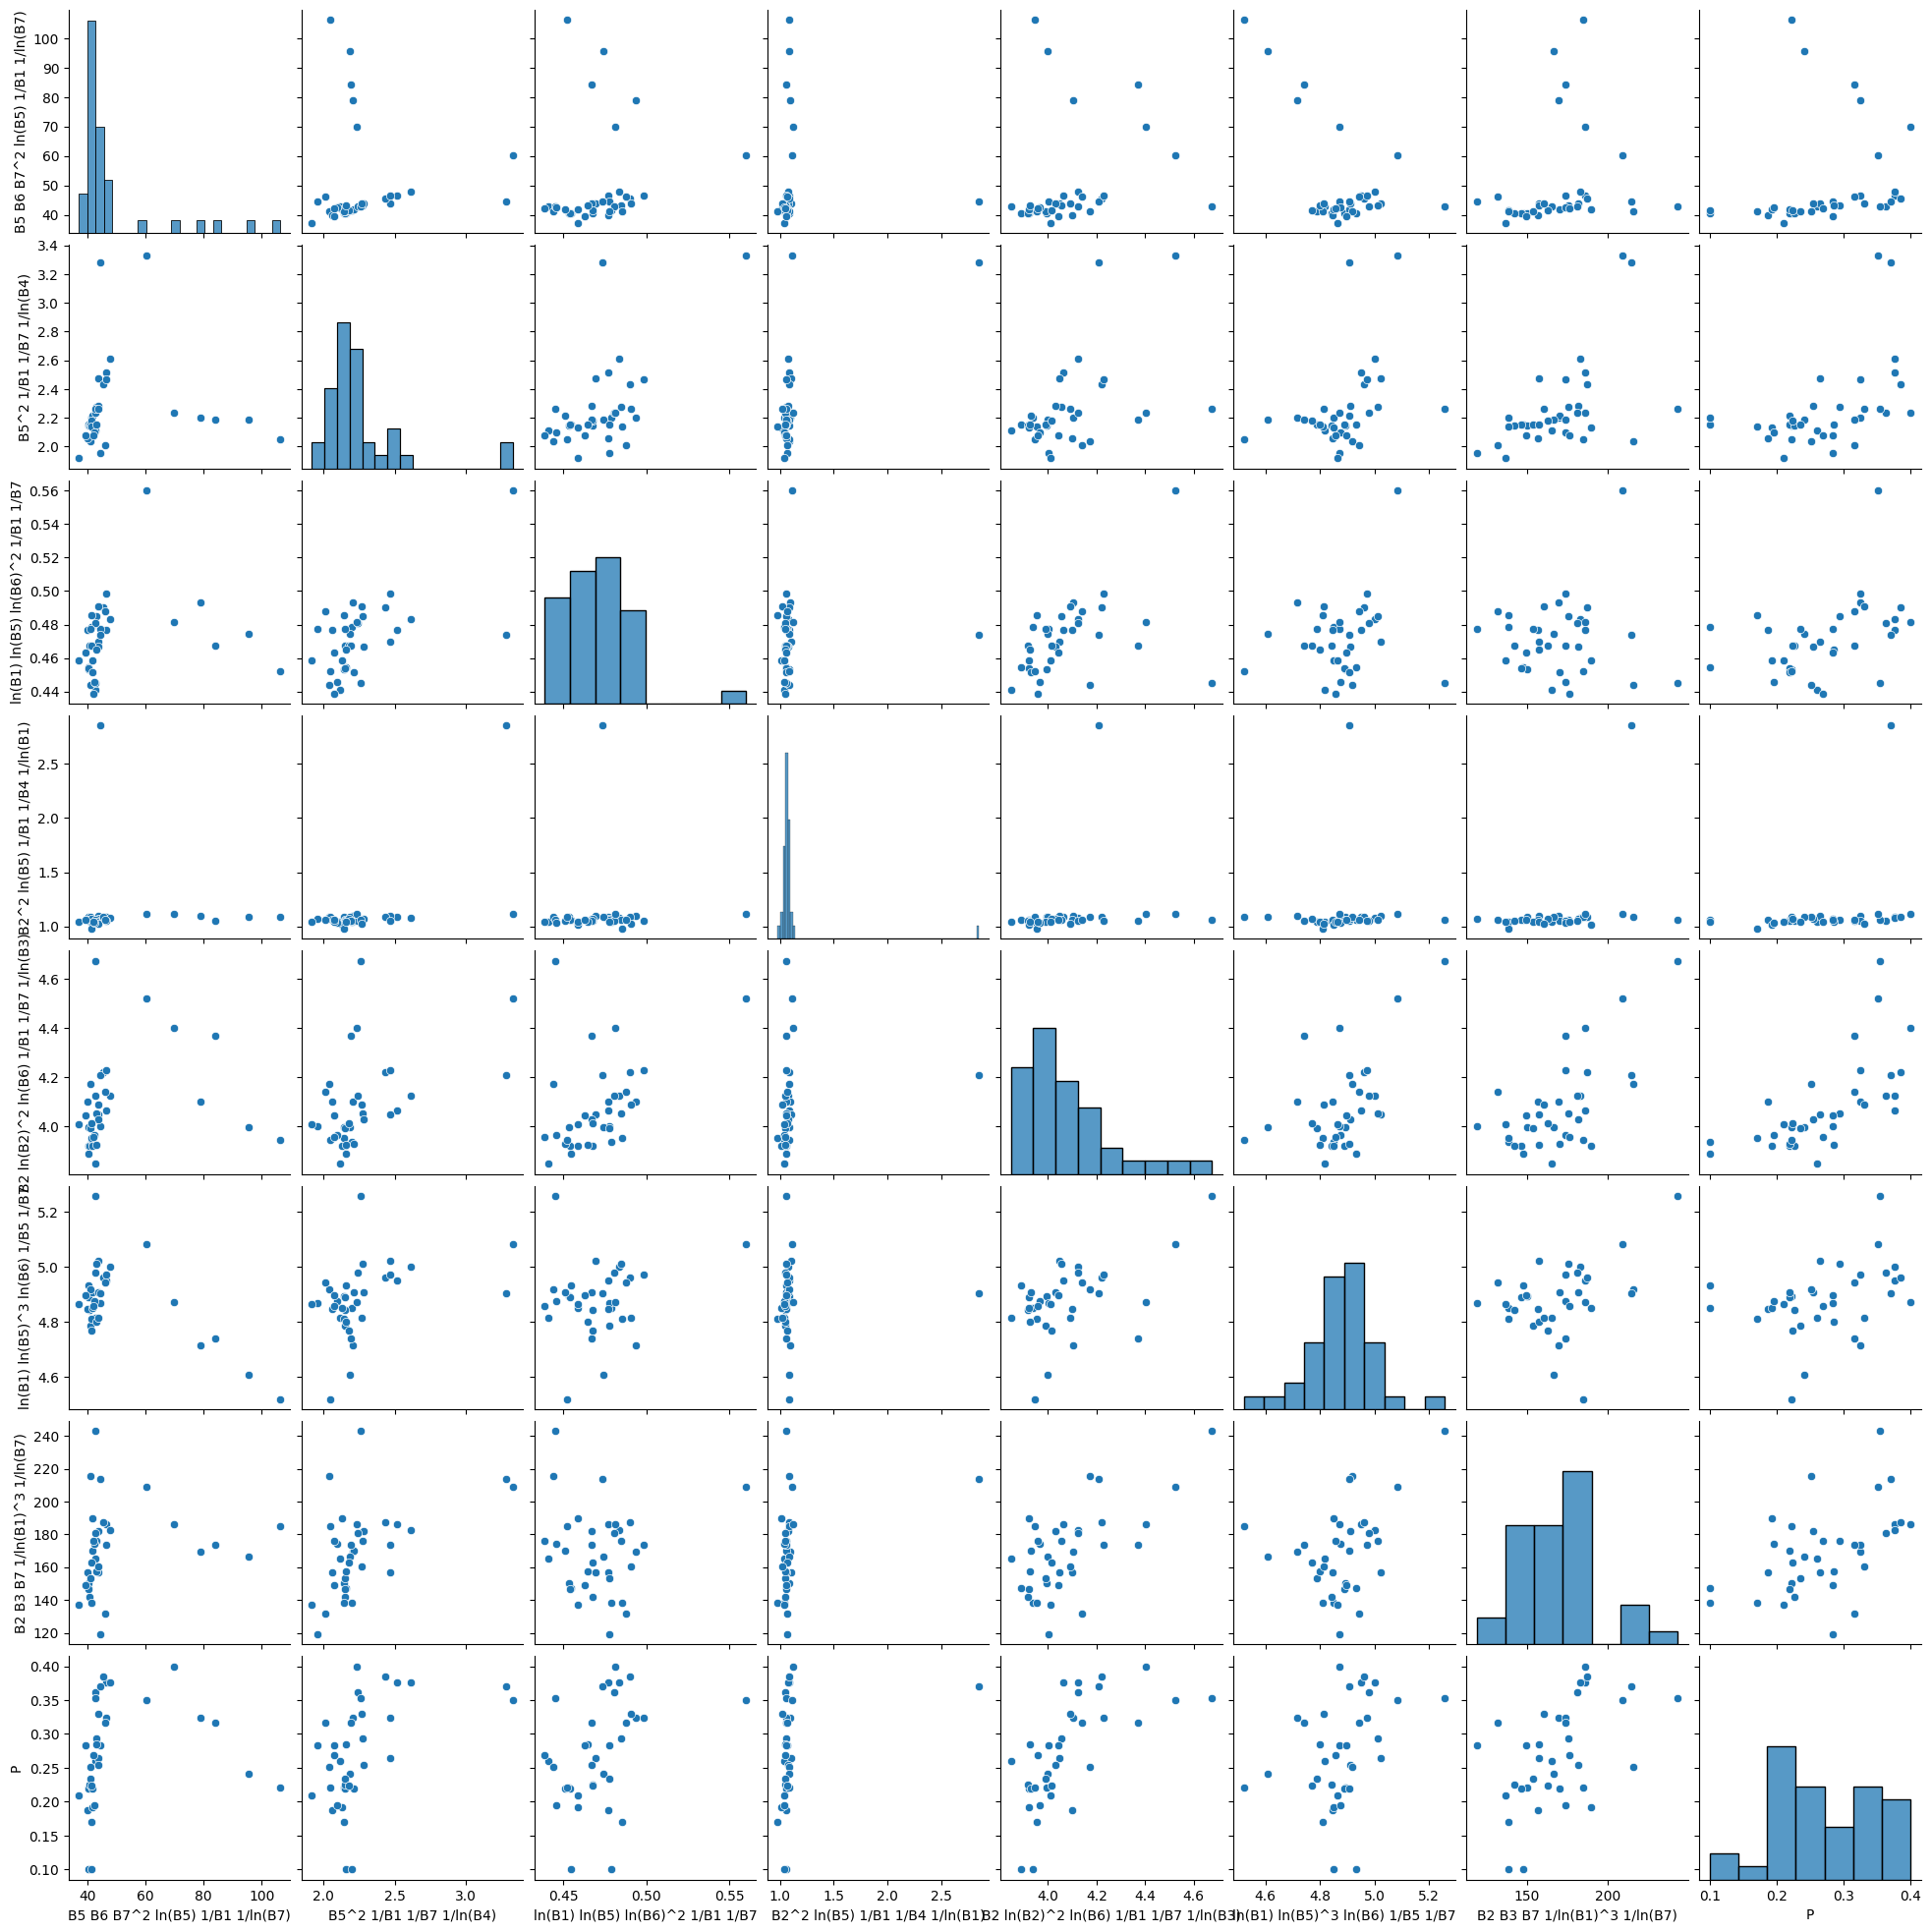

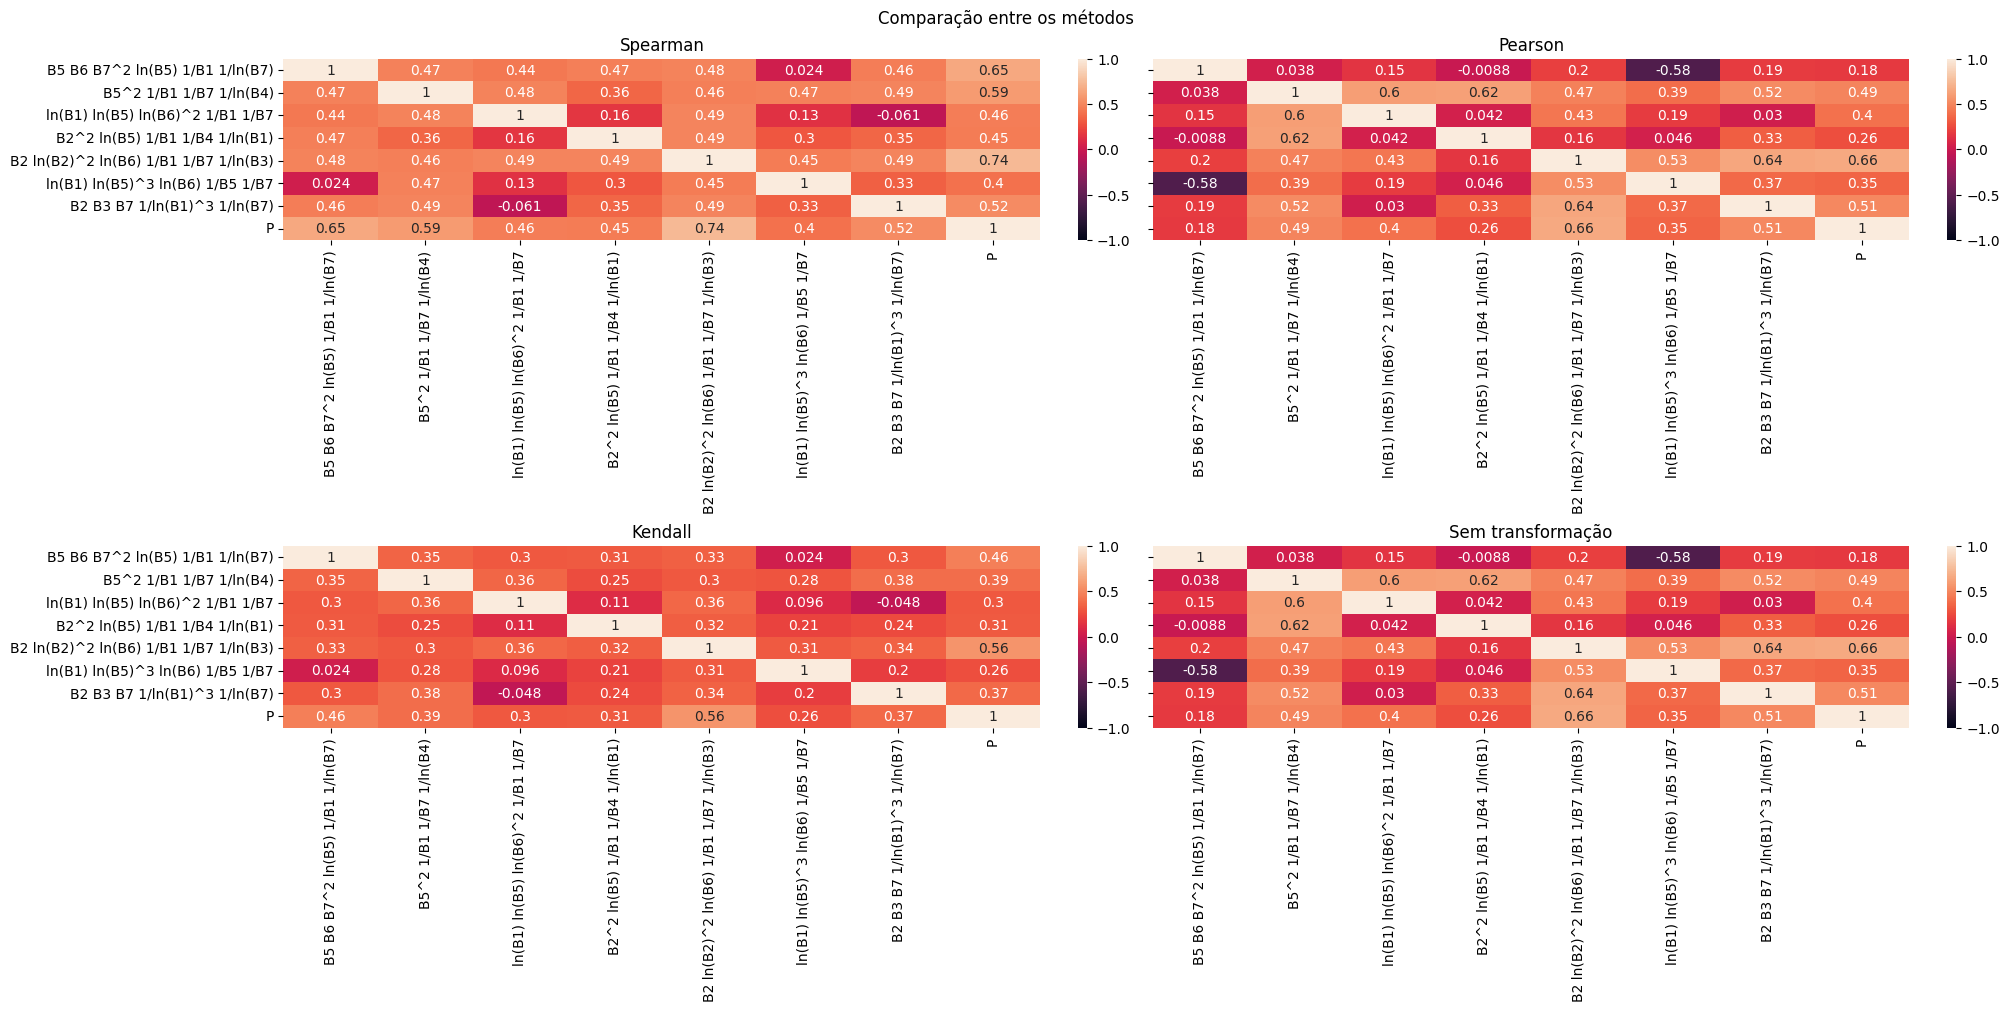

In [ ]:
sns.pairplot(df)
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True, constrained_layout=True)
fig.suptitle('Comparação entre os métodos')

#Spearman
ax = sns.heatmap(df.corr(method='spearman'), annot=True, vmin=-1, vmax=1, ax = axes[0,0])
axes[0,0].set_title("Spearman")
bottom, top = ax.get_ylim()

#Pearson
ax = sns.heatmap(df.corr(method='pearson'), annot=True, vmin=-1, vmax=1, ax = axes[0,1])
axes[0,1].set_title("Pearson")
bottom, top = ax.get_ylim()

#Kendall
ax = sns.heatmap(df.corr(method='kendall'), annot=True, vmin=-1, vmax=1, ax = axes[1,0])
bottom, top = ax.get_ylim()
axes[1,0].set_title("Kendall")

#Sem transformação
ax = sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, ax = axes[1,1])
axes[1,1].set_title("Sem transformação")
bottom, top = ax.get_ylim()

# 11. Regression Algorithms

In [245]:
def plot_results(y_pred, y_tes):
  plt.rcParams["figure.figsize"] = (10,5)
  plt.scatter(range(len(y_pred)), y_pred, c='r')
  plt.plot(range(len(y_tes)), y_tes, linestyle="-", marker="o", label="Expenses")
  plt.title('Model performance - test set')
  plt.ylabel('P medido')
  plt.xlabel('Sample')
  plt.legend(['predicted', 'real'], loc='upper left')
  plt.show()

Before we implement the regression models, I would like to clarify that we will use two main metrics to evaluate the performance of our models:


  * Mean Absolute Percentage Error (MAPE):
  \begin{equation}
    MAPE = \frac{1}{n} \sum_{i = 1}^{n} \frac{|y_i - p_i|}{y_i}
  \end{equation}

  * Mean Absolute Error (MAE):
  \begin{equation}
    MAE = \frac{1}{n} \sum_{i = 1}^{n} |y_i - p_i|
  \end{equation}

  * $R^2$ score:
  \begin{equation}
    R^2 = NSE = 1 - \frac{\sum_{i=1}^{N} (y_i - p_i)^2}{\sum_{i=1}^{N} (y_i - \bar{y_i})^2}
  \end{equation}


Where $y_i$ is the actual value, $p_i$ is the value predicted by the tested model, and $\bar{y_i}$ is the average of the $y_i$ values, $\forall i$.


## 11.1. Linear Methods

In [246]:
import sklearn.model_selection as skms
import sklearn.linear_model as sklm
import sklearn as sk
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, r_regression

In [247]:
def inverse_box_cox(y, lambda_):
  if lambda_ == 0:
    return np.exp(y)
  else:
    return np.log(1 + lambda_*y)/np.log(lambda_)

def inverse_square_root(y):
  return y**2

In [260]:
def cross_validation(x_train, y_train, folds, inv_y=False):

    splits = create_cont_folds(y_train, n_s=folds, n_grp=10, seed=4)
    x_tr = np.array(x_train)
    y_tr = np.array(y_train)
    histories = []
    models = []
    results = []

    for train_index, test_index in splits:
        xtr, xva = x_tr[train_index], x_tr[test_index]
        ytr, yva = y_tr[train_index], y_tr[test_index]

        model = sklm.LinearRegression()
        model.fit(xtr, ytr)
        y_pred = model.predict(xva)

        if inv_y:
            y_pred = inverse_square_root(y_pred)
            yva = inverse_square_root(yva)


        r2 = r2_score(yva, y_pred)
        mae = mean_absolute_error(yva, y_pred)
        mape = mean_absolute_percentage_error(yva, y_pred)
        mse = mean_squared_error(yva, y_pred)
        result = {'r2':r2, 'mae':mae, 'mape':mape, 'mse':mse}
        results.append(result)

    return results

In [249]:
def train_test_model(model, x_tr, y_tr, x_te, y_te, inv_y=False, folds=5):
  scores = cross_validation(x_tr, y_tr, folds=folds, inv_y=inv_y)

  mae = np.mean([val['mae'] for val in scores])
  std_mae = np.std([val['mae'] for val in scores])

  mape = np.mean([val['mape'] for val in scores])
  std_mape = np.std([val['mape'] for val in scores])

  mse = np.mean([val['mse'] for val in scores])
  std_mse = np.std([val['mse'] for val in scores])

  r2 = np.mean([val['r2'] for val in scores])
  std_r2 = np.std([val['r2'] for val in scores])

  print('--------------------Validação Cruazada-----------------------')
  print("Média dos valore de MAE: " + str(mae))
  print("Desvio padrão dos valore de MAE: " + str(std_mae) + "\n")

  print("Média dos valore de MAPE: " + str(mape))
  print("Desvio padrão dos valore de MAPE: " + str(std_mape) + "\n")

  print("Média dos valore de MSE: " + str(mse))
  print("Desvio padrão dos valore de MSE: " + str(std_mse) + "\n")

  print("Média dos valore de R2: " + str(r2))
  print("Desvio padrão dos valore de R2: " + str(std_r2) + "\n")

  print('--------------------Teste-----------------------')
  model.fit(x_tr, y_tr)
  y_pred = model.predict(x_te)

  if inv_y:
      y_pred = inverse_square_root(y_pred)
      y_te = inverse_square_root(y_te)

  print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
  print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
  print("MSE: " + str(mean_squared_error(y_te, y_pred)))
  print("R2: " + str(r2_score(y_te, y_pred)))

  plot_results(y_pred, y_te)

### 11.2.1. Linear Regression

In [250]:
def rfe(model_type, data, objective, factor=0.5):
    x = data[0]
    y = data[1]
    
#     terms = sum([s(i) for i in range(len(x.columns))], start=s(0))
#     model = LinearGAM(terms).fit(x, y)
    
    if model_type == 'lasso':
        model = Lasso(alpha=10/len(x.columns))
        model.fit(x,y)
        columns_list = x.columns.tolist()
        coef_list = list(model.coef_)
        
    if model_type == 'ridge':
        model = Ridge(alpha=10/len(x.columns))
        model.fit(x,y)
        columns_list = x.columns.tolist()
        coef_list = list(model.coef_)
        
    if model_type == 'linear_regression':
        model = sklm.LinearRegression()
        model.fit(x,y)
        columns_list = x.columns.tolist()
        coef_list = list(model.coef_)
        
    if model_type == 'decision_tree':
        model = DecisionTreeRegressor(random_state = 2)
        model.fit(x,y)
        columns_list = x.columns.tolist()
        coef_list = list(model.feature_importances_)
        
    if model_type == 'elastic_net':
        model = ElasticNet(alpha=10/len(x.columns))
        model.fit(x,y)
        columns_list = x.columns.tolist()
        coef_list = list(model.coef_)
        
    
    columns_list = [col for _, col in sorted(zip(coef_list, columns_list))]
    col_qnt = round(factor*len(columns_list))
    
    if len(columns_list) - col_qnt > objective:
        x = x.drop(columns=columns_list[:col_qnt])
        x = rfe(model_type, (x,y), objective, factor=factor)
    else:
        x = x.drop(columns=columns_list[:-objective])
        return x
    return x

Index(['B2 ln(B3)^2 ln(B5) 1/B3 1/B5', 'ln(B2) ln(B4)^3 ln(B5) 1/B4',
       'B1 B4 ln(B5) 1/B2^2 1/B6 1/ln(B6)', 'B1 ln(B4)^2 1/B2 1/B6^2 1/B7',
       'B2 B5 ln(B7)^2 1/B6^2 1/B7', 'ln(B1)^2 ln(B5)^2 ln(B6) 1/B1 1/B5',
       'ln(B3)^4 ln(B5) 1/B3 1/ln(B2)', 'ln(B3) ln(B5)^4 1/B5 1/ln(B5)',
       'ln(B6)^3 1/B1 1/B4 1/B5 1/B7', 'ln(B7) 1/B3^2 1/B6^3 1/ln(B6)'],
      dtype='object')
--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.06772922708916812
Desvio padrão dos valore de MAE: 0.038812898404740136

Média dos valore de MAPE: 0.8409469051063434
Desvio padrão dos valore de MAPE: 0.28429666513971447

Média dos valore de MSE: 0.01209850786937874
Desvio padrão dos valore de MSE: 0.012599860061859593

Média dos valore de R2: -1.0980552875792051
Desvio padrão dos valore de R2: 1.8153825182142254

--------------------Teste-----------------------
MAE: 0.035957825023818724
MAPE: 0.5238434860102757
MSE: 0.00248796197710919
R2: 0.5415115426674704


/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


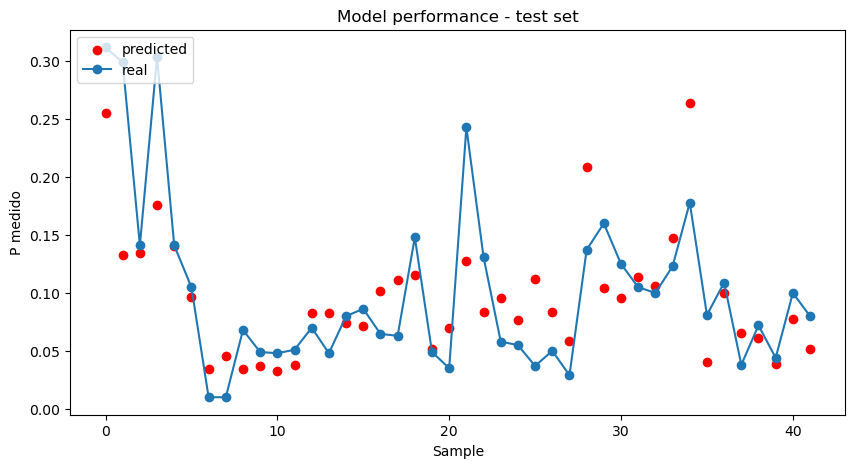

Index(['ln(B3) ln(B5)^3 1/B5', 'B2^2 ln(B7) 1/B3^2 1/B5',
       'B2 B6 ln(B4) ln(B6) 1/B1 1/B4', 'B2 ln(B3)^3 1/B3 1/ln(B2)',
       'B2 ln(B3)^2 ln(B5) 1/B3 1/B5', 'B6^2 1/B1 1/B4 1/B5 1/B7',
       'B6 ln(B2) ln(B3) 1/B7 1/ln(B2)^2', 'B6 ln(B3) ln(B5)^2 1/B5 1/B7',
       'B6 ln(B6) 1/B1 1/B4 1/B5 1/B7', 'B7 ln(B3)^3 1/B3 1/ln(B6)',
       'ln(B1) ln(B3)^4 1/B3', 'ln(B1) 1/B2 1/B7^4',
       'ln(B2) ln(B4)^3 ln(B5) 1/B4', 'ln(B2) ln(B5)^2 ln(B6) 1/B5 1/B7',
       'ln(B3)^4 ln(B5) 1/B3', 'ln(B3) ln(B4)^3 ln(B5) 1/B4',
       'ln(B3) ln(B5)^2 ln(B6) 1/B5 1/B7', 'ln(B5)^3 ln(B6) 1/B5 1/B6',
       'ln(B5)^2 ln(B6)^2 1/B5 1/B6', 'ln(B6)^2 1/B1 1/B4 1/B5 1/B7',
       'B1^4 B6^2 ln(B7)', 'B1^4 ln(B7)^2 1/B3',
       'B1 B4 ln(B3) 1/B3 1/B6^2 1/B7', 'B1 B4 ln(B5) 1/B2^2 1/B6 1/ln(B6)',
       'B1 B4 1/B2 1/B6^3 1/ln(B3)', 'B1 B4 1/B3 1/B6^3 1/B7',
       'B1 ln(B4)^2 1/B2 1/B6^2 1/B7', 'B2 B5 ln(B7)^2 1/B1 1/B6 1/B7',
       'B2 B5 ln(B7)^2 1/B1 1/B7^2', 'B2 B5 ln(B7)^2 1/B6^2 1/B7',
   

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


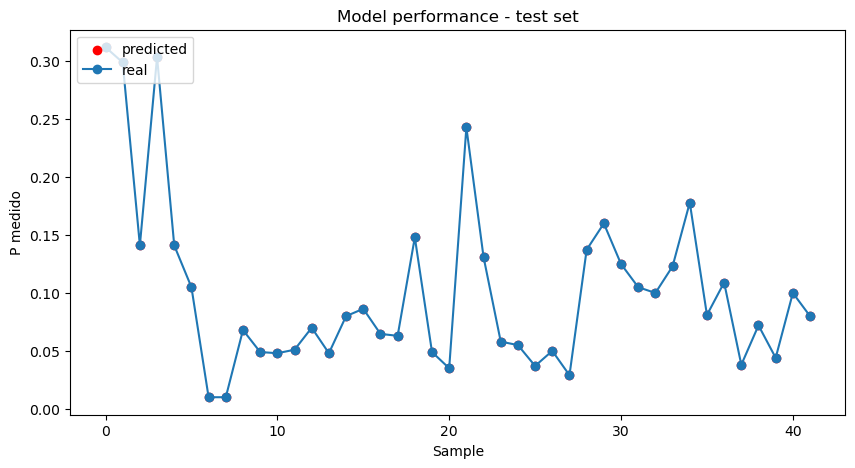

Index(['B1 B4 ln(B5) 1/B2 1/B6^3', 'B2 ln(B4) ln(B6)^2 1/B1 1/B4 1/ln(B5)',
       'B5 ln(B4) ln(B7)^2 1/B7^2 1/ln(B6)',
       'B6 ln(B3) ln(B5)^2 1/B5 1/B7 1/ln(B1)',
       'B7 ln(B1) ln(B4) ln(B5) 1/B6 1/ln(B2)^2',
       'ln(B1) ln(B2) ln(B5)^2 ln(B6) 1/B5 1/B7',
       'ln(B2)^2 ln(B4)^3 1/B4 1/ln(B3)', 'ln(B4)^3 ln(B5) ln(B6) 1/B4 1/B6',
       '1/B1 1/B3 1/B4^5', '1/B2 1/B7^4 1/ln(B2) 1/ln(B4)'],
      dtype='object')
--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.20420451597788528
Desvio padrão dos valore de MAE: 0.3182705335926256

Média dos valore de MAPE: 1.1233700274144502
Desvio padrão dos valore de MAPE: 0.9230212214883733

Média dos valore de MSE: 1.1370846302555992
Desvio padrão dos valore de MSE: 2.2650172336664873

Média dos valore de R2: -184.20176536561306
Desvio padrão dos valore de R2: 368.0934534873148

--------------------Teste-----------------------
MAE: 0.02925519815742357
MAPE: 0.4356859183078311
MSE: 0.0022525272201

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


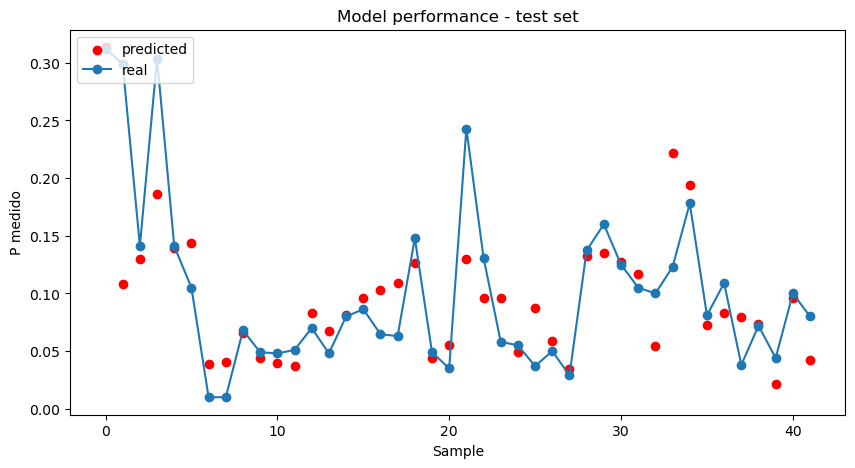

In [251]:
def test_rfe(objective, factor):
    x = poly_df
    x = (x - x.min())/(x.max() - x.min())
    x = rfe('linear_regression', (x,y), objective, factor=factor)
    print(x.columns)
    # x = poly_df[x.columns]

    linear_regressor = sklm.LinearRegression()
    train_test_model(linear_regressor, x, y, x, y, inv_y=True, folds=5)
    
test_list = [(10, 0.3), (100, 0.3), (10, 0.05)]
for i in test_list:
    test_rfe(i[0], i[1])

Index(['B1^2 B6 ln(B4) 1/B3 1/B5^2', 'B1^2 B7 ln(B4) 1/B2^2 1/B5',
       'B1^2 B7 ln(B4) 1/B2 1/B3 1/B5', 'B1^2 B7 ln(B4) 1/B2 1/B5^2',
       'B1^2 B7 ln(B4) 1/B3 1/B5^2', 'B1 B7^2 ln(B4) 1/B3 1/B5^2',
       'B1 B7^2 ln(B4) 1/B3 1/B5 1/B6',
       'B1 B7 ln(B1) ln(B4) 1/B3 1/B5 1/ln(B5)',
       'B1 B7 ln(B2) ln(B4) 1/B3 1/B5 1/ln(B5)',
       'B1 B7 ln(B3) ln(B4) 1/B3 1/B5 1/ln(B5)'],
      dtype='object')
--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.06847547646150401
Desvio padrão dos valore de MAE: 0.0230652814993857

Média dos valore de MAPE: 0.8645259389156713
Desvio padrão dos valore de MAPE: 0.29598001447594346

Média dos valore de MSE: 0.012486934939399638
Desvio padrão dos valore de MSE: 0.009464115636533588

Média dos valore de R2: -2.9297185345271
Desvio padrão dos valore de R2: 5.193255732851858

--------------------Teste-----------------------
MAE: 0.03713629848271659
MAPE: 0.5393941587130991
MSE: 0.0030173223039893014
R2: 0.4

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


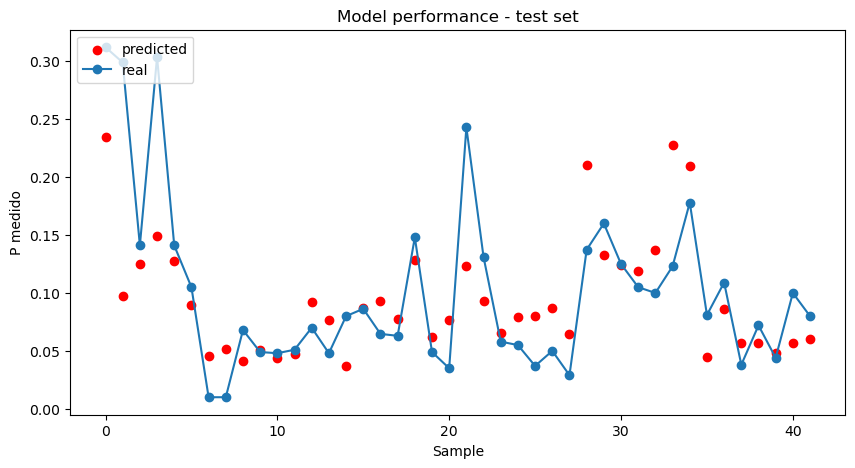

Index(['B1 B6 B7 1/B3 1/B5^2', 'B1^2 ln(B6) 1/B2 1/B5 1/ln(B1) 1/ln(B3)',
       'B1 B4 B7 1/B3 1/B5 1/ln(B4) 1/ln(B6)',
       'B1 B6^2 1/B5^2 1/ln(B3) 1/ln(B6)', 'B1 B6 ln(B5) ln(B6) 1/B3 1/B5^2',
       'B2 ln(B2) 1/B1 1/ln(B3)^2 1/ln(B5)^2',
       'B2 ln(B3) ln(B6) 1/B3 1/ln(B2) 1/ln(B5)^2',
       'B3 B5^2 1/B1 1/B6 1/ln(B5) 1/ln(B6)',
       'B3 ln(B1) ln(B5)^2 1/B2 1/ln(B2) 1/ln(B6)',
       'ln(B2) ln(B3) ln(B5)^2 1/ln(B1)^2 1/ln(B6)'],
      dtype='object')
--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.0538242867319346
Desvio padrão dos valore de MAE: 0.023170357710774664

Média dos valore de MAPE: 0.7217546541720707
Desvio padrão dos valore de MAPE: 0.21817951425774051

Média dos valore de MSE: 0.005594273445844081
Desvio padrão dos valore de MSE: 0.0050051512232527524

Média dos valore de R2: -0.06536313809059388
Desvio padrão dos valore de R2: 0.5263446074340814

--------------------Teste-----------------------
MAE: 0.035087846926

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


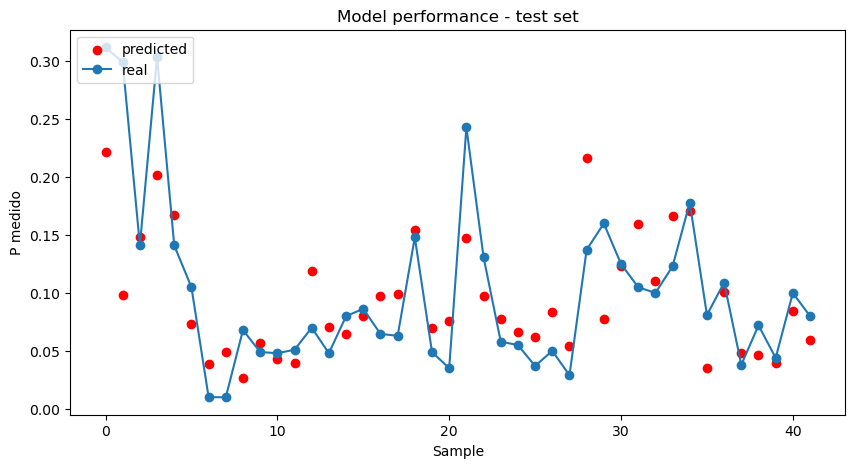

Index(['B3 B5 ln(B5) 1/B1 1/B6 1/ln(B4)',
       'B3 B5^2 ln(B1) 1/B1 1/ln(B4) 1/ln(B7)',
       'B3 B5^2 ln(B2) 1/B1 1/ln(B4) 1/ln(B7)',
       'B3 B5^2 ln(B3) 1/B1 1/ln(B4) 1/ln(B7)',
       'B3 B5^2 ln(B5) 1/B1 1/ln(B4) 1/ln(B7)',
       'B3 B5^2 1/B1 1/B6 1/B7 1/ln(B4)',
       'B3 B5^2 1/B1 1/B6 1/ln(B4) 1/ln(B6)', 'B3 B5^2 1/B1 1/B7^2 1/ln(B4)',
       'B3 B5 B6 ln(B5) 1/B1 1/ln(B4) 1/ln(B7)',
       'B3 B5 ln(B5) 1/B1 1/B7 1/ln(B1) 1/ln(B4)'],
      dtype='object')
--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.0665218309681942
Desvio padrão dos valore de MAE: 0.03587542821209166

Média dos valore de MAPE: 0.8643533207317582
Desvio padrão dos valore de MAPE: 0.37601223788026694

Média dos valore de MSE: 0.0172182000641055
Desvio padrão dos valore de MSE: 0.0223260066534257

Média dos valore de R2: -5.5894186949275335
Desvio padrão dos valore de R2: 11.137549512635864

--------------------Teste-----------------------
MAE: 0.03308736238614

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


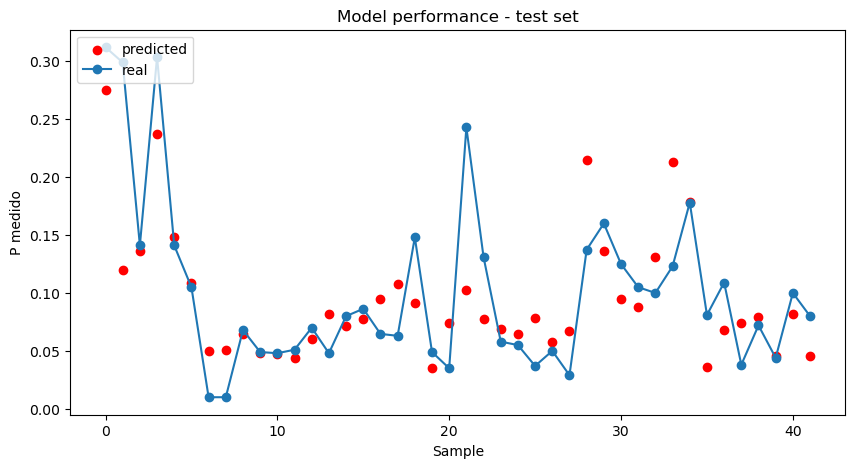

In [261]:
def test_kbest(score_func, k):
    x = poly_df
    x = (x - x.min())/(x.max() - x.min())
    selector = SelectKBest(score_func=score_func, k=k)
    x = selector.fit_transform(x, y)
    print(poly_df.columns[selector.get_support()])
    x = poly_df[poly_df.columns[selector.get_support()]]

    linear_regressor = sklm.LinearRegression()
    train_test_model(linear_regressor, x, y, x, y, inv_y=True, folds=5)
    

test_list = [(f_regression, 10), (mutual_info_regression, 10), (r_regression, 10)]
for i in test_list:
    test_kbest(i[0], i[1])

In [205]:
selector = SelectKBest(score_func=f_regression, k=10)
x = selector.fit_transform(x, y)

In [107]:
x = rfe('decision_tree', (x,y), 10, factor=0.3)

In [112]:
x = rfe('linear_regression', (x,y), 10, factor=0.05)

In [ ]:
x = rfe('lasso', (x,y), 10, factor=0.05)

In [208]:
poly_df.columns[selector.get_support()]

Index(['B1^2 B6 ln(B4) 1/B3 1/B5^2', 'B1^2 B7 ln(B4) 1/B2^2 1/B5',
       'B1^2 B7 ln(B4) 1/B2 1/B3 1/B5', 'B1^2 B7 ln(B4) 1/B2 1/B5^2',
       'B1^2 B7 ln(B4) 1/B3 1/B5^2', 'B1 B7^2 ln(B4) 1/B3 1/B5^2',
       'B1 B7^2 ln(B4) 1/B3 1/B5 1/B6',
       'B1 B7 ln(B1) ln(B4) 1/B3 1/B5 1/ln(B5)',
       'B1 B7 ln(B2) ln(B4) 1/B3 1/B5 1/ln(B5)',
       'B1 B7 ln(B3) ln(B4) 1/B3 1/B5 1/ln(B5)'],
      dtype='object')

**Using only train set**

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.05706669881672462
Desvio padrão dos valore de MAE: 0.03421356654611268

Média dos valore de MAPE: 0.8109394759776271
Desvio padrão dos valore de MAPE: 0.3844697466315917

Média dos valore de MSE: 0.006653834447577066
Desvio padrão dos valore de MSE: 0.0075604629816018514

Média dos valore de R2: -0.19019256485587557
Desvio padrão dos valore de R2: 0.882556009327989

--------------------Teste-----------------------
MAE: 0.03514893118890528
MAPE: 0.5107202502221128
MSE: 0.002542385232009622
R2: 0.5314822759777492


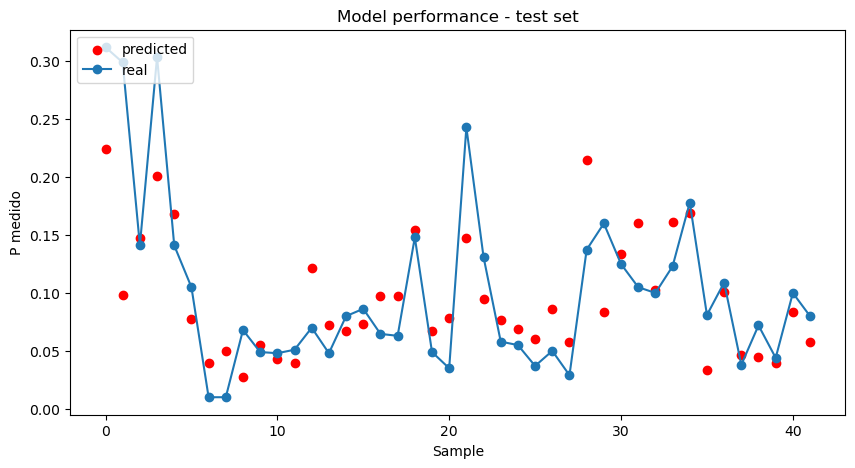

In [147]:
linear_regressor = sklm.LinearRegression()
train_test_model(linear_regressor, x, y, x, y, inv_y=True, folds=5)

**Using train and test sets**

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.3246990765529021
Desvio padrão dos valore de MAE: 0.27004006824649757

Média dos valore de MAPE: 4.174402856521761
Desvio padrão dos valore de MAPE: 3.498766617023072

Média dos valore de MSE: 0.6172883698144975
Desvio padrão dos valore de MSE: 0.875244829653366

Média dos valore de R2: -93.55441497653081
Desvio padrão dos valore de R2: 131.1705986366225

--------------------Teste-----------------------
MAE: 0.07636585984599875
MAPE: 3.0470231504153307
MSE: 0.007897204034764366
R2: -2.6879385226044974


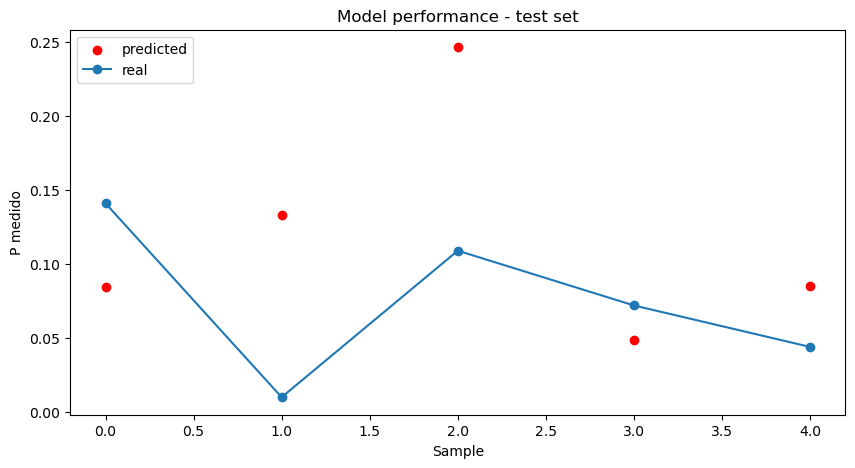

In [148]:
linear_regressor = sklm.LinearRegression()
train_test_model(linear_regressor, x_tr, y_tr, x_te, y_te, inv_y=True, folds=4)

In [115]:
print("Coeficientes da regressão linear: " + str(linear_regressor.coef_))

Coeficientes da regressão linear: [-2.90646481e-05 -4.95057406e-05 -1.03073289e-05 ...  4.52742510e-04
  5.59143530e-04  6.52039140e-04]


In [ ]:
linear_coef = [abs(i) for i in list(linear_regressor.coef_)]

In [145]:
!pip install pygam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 2.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.8 MB/s eta 0:00:00


In [146]:
from pygam import LinearGAM, s, l

In [ ]:
x = rfe(None, (x,y), 10, factor=0.3)

In [ ]:
terms = sum([s(i) for i in range(len(x.columns))], start=s(0))
gam = LinearGAM(terms)
train_test_model(gam, x, y, x, y, inv_y=True, folds=5)

### 11.2.2. Ridge Regression

In [ ]:
ray.init()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
# definindo espaço de busca para os lambdas
lambdas = np.linspace(0, 1000000, 10000)

**5-Folds**

In [ ]:
@ray.remote

def test_lambda(lamb):
  # aplicando a regressão
  ridge = sklm.Ridge(alpha = lamb)
  ridge.fit(x_tr, y_tr)             # Fit a ridge regression on the training data

  scores = skms.cross_validate(ridge, x_tr, y_tr, cv=5,
                               scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'))

  mae = np.mean(scores['test_neg_mean_absolute_error']*(-1))
  mape = np.mean(scores['test_neg_mean_absolute_percentage_error']*(-1))
  r2 = np.mean(scores['test_r2'])

  return [mae, mape, r2]

In [ ]:
result_values = ray.get([test_lambda.remote(i) for i in lambdas])
scores_MAE = [result[0] for result in result_values]
scores_MAPE = [result[1] for result in result_values]
scores_R2 = [result[2] for result in result_values]

In [ ]:
best_index = scores_MAE.index(min(scores_MAE))

print("Lambda:" + str(lambdas[best_index]))
print("Best MAE: " + str(scores_MAE[best_index]))
print("Best MAPE: " + str(scores_MAPE[best_index]))
print("R2: " + str(scores_R2[best_index]))

ridge = sklm.Ridge(alpha = lambdas[best_index])
ridge.fit(x_tr, y_tr)
plot_results(ridge.predict(x_te), y_te)

**10-folds**

In [ ]:
@ray.remote

def test_lambda(lamb):
  # aplicando a regressão
  ridge = sklm.Ridge(alpha = lamb)
  ridge.fit(x_tr, y_tr)             # Fit a ridge regression on the training data

  scores = skms.cross_validate(ridge, x_tr, y_tr, cv=10,
                               scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'))

  mae = np.mean(scores['test_neg_mean_absolute_error']*(-1))
  mape = np.mean(scores['test_neg_mean_absolute_percentage_error']*(-1))
  r2 = np.mean(scores['test_r2'])

  return [mae, mape, r2]

In [ ]:
result_values = ray.get([test_lambda.remote(i) for i in lambdas])
scores_MAE = [result[0] for result in result_values]
scores_MAPE = [result[1] for result in result_values]
scores_R2 = [result[2] for result in result_values]

In [ ]:
best_index = scores_MAE.index(min(scores_MAE))

print("Lambda:" + str(lambdas[best_index]))
print("Best MAE: " + str(scores_MAE[best_index]))
print("Best MAPE: " + str(scores_MAPE[best_index]))
print("R2: " + str(scores_R2[best_index]))

ridge = sklm.Ridge(alpha = lambdas[best_index])
ridge.fit(x_tr, y_tr)
plot_results(ridge.predict(x_te), y_te)

In [ ]:
y_pred = ridge.predict(x_te)
print('-----------Teste-------------')
print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
print("R2: " + str(r2_score(y_te, y_pred)))

## 11.2 Non-linear Methods

### 11.2.1. SVM

In [ ]:
from sklearn import svm

**5-Folds**

In [ ]:
svm_regressor = svm.SVR()
train_test_model(svm_regressor, x_tr, y_tr, x_te, y_te, folds=5)

**10-Folds**

In [ ]:
train_test_model(svm_regressor, x_tr, y_tr, x_te, y_te, folds=10)

### 11.2.2. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor as rf

In [ ]:
rf_regressor = rf(n_estimators=1000, random_state=1)
rf_regressor.fit(x_tr, y_tr)

**5-Folds**

In [ ]:
train_test_model(rf_regressor, x_tr, y_tr, x_te, y_te, folds=5)

**10-Folds**

In [ ]:
train_test_model(rf_regressor, x_tr, y_tr, x_te, y_te, folds=10)

### 11.2.3 Gradient Boost

In [ ]:
import catboost as cb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from  sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [ ]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [2, 3, 5, 7, 10],
        'min_samples_split': [2, 5, 10, 20],
        'max_features': ['log2', 0.25, 'sqrt', 1.0],
        'subsample': [0.15, 0.5, 0.75, 1.0]}

clf = GridSearchCV(GradientBoostingRegressor(n_estimators=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_tr)
clf.best_params_

In [ ]:
gb = GradientBoostingRegressor(n_estimators=200,learning_rate=0.025,
 max_depth=3,
 max_features='log2',
 min_samples_split=2,
 subsample=0.15
)


train_test_model(gb, x_tr, y_tr, x_te, y_te, folds=10)

### 11.2.4 CatBoost

In [ ]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 6, 9],
        'leaf_estimation_iterations': [1, 10],
        'l2_leaf_reg': [1, 3, 6, 9]}

clf = GridSearchCV(CatBoostRegressor(iterations=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_tr)
clf.best_params_

In [ ]:
ctb = CatBoostRegressor(n_estimators=200,l2_leaf_reg= 1,
 leaf_estimation_iterations= 10,
 learning_rate= 0.3,
 max_depth= 6)


train_test_model(ctb, x_tr, y_tr, x_te, y_te, folds=10)

In [ ]:
ctb.get_feature_importance(prettified=True)

### 11.2.5 XGBoost

In [ ]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [2, 3, 5, 7, 10, 100],
        'gamma':[0, 0.1, 0.2, 0.3, 0.4, 1.0, 1.5, 2.0],
        'colsample_bylevel': ['log2', 'sqrt', 0.25, 1.0],
        'subsample': [0.15, 0.5, 0.75, 1.0]}

clf = GridSearchCV(XGBRegressor(n_estimators=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_tr)
clf.best_params_

In [ ]:
xgb = XGBRegressor(n_estimators=200,colsample_bylevel=0.25,
 gamma=0,
 learning_rate=0.025,
 max_depth=10,
 subsample=0.15
)


train_test_model(ctb, x_tr, y_tr, x_te, y_te, folds=10)

In [ ]:
%%capture
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%writefile no_code.tpl
{% extends 'article.tplx' %}

{% block input_group %}
{% endblock input_group %}

In [ ]:
!cp /content/drive/MyDrive/CNN_Chagas/fosforo/Cópia_de_Analise_fosforo.ipynb ./

In [ ]:
!jupyter nbconvert --to pdf  "Cópia_de_Analise_fosforo.ipynb"